In [12]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 


In [3]:
usr = pd.read_csv('data/user_ratings.csv')
usr.head()

,BGGId,Rating,Username
0,213788,8.0,Tonydorrf
1,213788,8.0,tachyon14k
2,213788,8.0,Ungotter
3,213788,8.0,brainlocki3
4,213788,8.0,PPMP


In [4]:
ratings_per_users = usr.groupby('Username').size()
ratings_per_movies = usr.groupby('BGGId').size()


<Axes: >

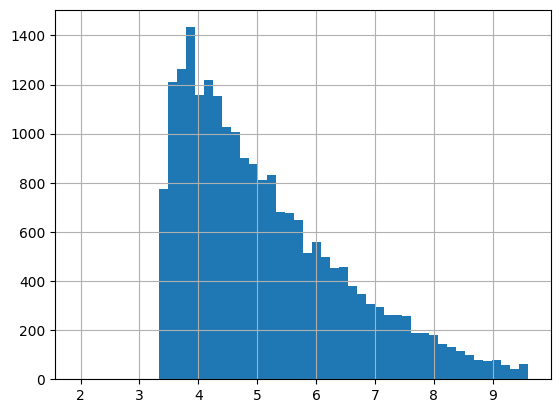

In [7]:
import numpy as np
#remove outliers
pctl_99 = ratings_per_movies.quantile(0.99)

np.log(ratings_per_movies[ratings_per_movies < pctl_99]).hist(bins=50)

In [21]:
usr['MappedRating'] = np.where(usr['Rating'] <= 4, -1,
                       np.where(usr['Rating'] <= 7, 0, 1))

In [23]:
usr.groupby('MappedRating').size() 

MappedRating
-1     996111
 0    9338811
 1    8361443
dtype: int64

In [6]:
keep = ratings_per_users[ratings_per_users >= 5].index
usr = usr[usr['Username'].isin(keep)]

<Axes: >

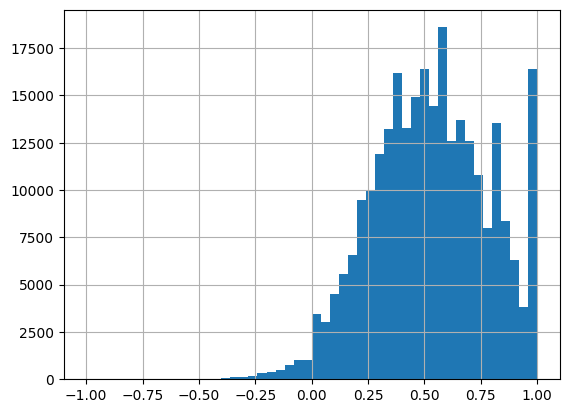

In [24]:
usr.groupby('Username')['MappedRating'].mean().hist(bins=50)


In [8]:
user_map = {u: i for i, u in enumerate(usr['Username'].unique())}
game_map = {g: j for j, g in enumerate(usr['BGGId'].unique())}

rows = usr['Username'].map(user_map)
cols = usr['BGGId'].map(game_map)

rows.shape

(18696365,)

In [25]:
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split

def create_A_matrix(users, items, ratings):
    user_map = {user: i for i, user in enumerate(users.unique())}
    item_map = {item: i for i, item in enumerate(items.unique())}
    rows = users.map(user_map)
    cols = items.map(item_map)

    #mask = ratings.notna()
    A = coo_matrix((ratings, (rows,cols)), shape=(len(user_map), len(item_map)))

    return A, user_map, item_map


A, user_map, item_map = create_A_matrix(usr['Username'], usr['BGGId'], usr['MappedRating'])
rows, cols, data = A.row, A.col, A.data
indices = np.arange(len(data))
train, test = train_test_split(indices, test_size=0.2, random_state=42)

train_rows, train_cols, train_data = rows[train], cols[train], data[train]
#val_rows, val_cols, val_data = rows[test_index], cols[test_index], data[test_index]

A_train = coo_matrix((train_data, (train_rows, train_cols)), shape=A.shape)


In [ ]:
def als(R, k=2, lambda_=0.1, n_iters=10 ):
    m, n = R.shape

    #Global mean
    mu = R.data.mean()
    
    # Initialize parameters
    U = np.random.normal(scale=1./k, size=(m, k))
    V = np.random.normal(scale=1./k, size=(n, k))
    b_user = np.zeros(m)
    b_item = np.zeros(n)

    #create two versions for row and column operations
    R_csr = R.tocsr()
    R_csc = R.tocsc()

    for _ in range(n_iters):
        #print(f'Iteration {_+1}/{n_iters}')
        # Update user features
        for i in range(m):
            start, end = R_csr.indptr[i], R_csr.indptr[i+1]
            idx  = R_csr.indices[start:end]
            r_i = R_csr.data[start:end] 
            if len(idx) > 0:
                V_i = V[idx, :]
                r_i_centered = r_i - mu - b_user[i] - b_item[idx]
                A = V_i.T @ V_i + lambda_ * np.eye(k)
                b = V_i.T @ r_i_centered
                U[i] = np.linalg.solve(A,b)

                #update user bias
                pred = V_i @ U[i]
                b_user[i] = np.mean(r_i - pred - mu - b_item[idx])

        # Update item features
        for j in range(n):
            start, end = R_csc.indptr[j], R_csc.indptr[j+1]
            idx  = R_csc.indices[start:end]            
            r_j = R_csc.data[start:end]
            if len(idx) > 0:
                U_j = U[idx,:]
                r_j_centered = r_j - mu - b_user[idx] - b_item[j]
                A = U_j.T @ U_j + lambda_ * np.eye(k)
                b = U_j.T @ r_j_centered
                V[j] = np.linalg.solve(A,b)

                #udate item bias    
                pred = U_j @ V[j]
                b_item[j] = np.mean(r_j - pred - mu - b_user[idx])
    return U, V, b_user, b_item, mu

In [27]:

from sklearn.model_selection import KFold

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))


def recall_at_k(U, V,A_val, k=10):
    recalls = []
    for u in range(U.shape[0]):
        row = A_val.getrow(u).tocoo()
        if row.nnz == 0:
            continue
        y_true = row.col[row.data >= 0] # liked items
        y_scores = U[u, :] @ V.T
        y_pred = np.argsort(-y_scores)[:k]  # top-k items

        hits = np.intersect1d(y_true, y_pred) # how many of the true liked items are in the top-k predictions
        recall = len(hits) / len(y_true) # fraction of hits that were in the top 10 predictions
        recalls.append(recall)
    
    return -np.mean(recalls) if recalls else np.nan
    

def cv_als(A, k=5, als_params = {'k':20, 'lambda':0.1, 'n_iters':10} ):

    rmses = []
    recalls = []
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    rows, cols, data = A.row, A.col, A.data
    indices = np.arange(len(data))

    for train_index, test_index in kf.split(indices):
        #print("TRAIN:", train_index, "TEST:", test_index)
        train_rows, train_cols, train_data = rows[train_index], cols[train_index], data[train_index]
        val_rows, val_cols, val_data = rows[test_index], cols[test_index], data[test_index]

        A_fold_train = coo_matrix((train_data, (train_rows, train_cols)), shape=A_train.shape)
        A_fold_val = coo_matrix((val_data, (val_rows, val_cols)), shape=A_train.shape)
        
        # Train your model on A_train here
        U, V, b_user, b_item, mu  = als(A_fold_train, k=als_params['k'], lambda_=als_params['lambda'], n_iters=als_params['n_iters'])
        # Evaluate your model on A_test here
        #A_pred = U @ V.T
        # Compute RMSE on the test set

        #test values
        y_test = A_fold_val.data

        #get predictions from the predicted matrix
        latent_pred = np.einsum('ij,ij->i', U[A_fold_val.row], V[A_fold_val.col])

        #add biases and global mean
        y_pred = mu + b_user[A_fold_val.row] + b_item[A_fold_val.col] + latent_pred
        r_at_k = recall_at_k(U, V, A_fold_val, k=10)
        rmse_ = rmse(y_test, y_pred)
        rmses.append(rmse_)
        recalls.append(r_at_k)

    return np.mean(rmses), np.mean(recalls)


In [ ]:
# grid search for hyperparameter tuning
import itertools
k_values = [5, 10]
lambda_values = [0.01, 0.1, 1.0]
n_iters_values = [5]
best_score = float('inf')
best_params = None
for k, lambda_, n_iters in itertools.product(k_values, lambda_values, n_iters_values):
    print(f'Evaluating for k={k}, lambda={lambda_}, n_iters={n_iters}')
    rmse, recall = cv_als(A_train, k=k, als_params={'k':k, 'lambda':lambda_, 'n_iters':n_iters})
    print(f'Average RMSE: {avg_score}, Average Recall@10: {recall}')
    if recall < best_score:
        best_score = recall
        best_params = (k, lambda_, n_iters)
print(f'Best params: k={best_params[0]}, lambda={best_params[1]}, n_iters={best_params[2]} with recall@k={best_score}')

Evaluating for k=5, lambda=0.01, n_iters=5


In [ ]:
U, V = als(A_train, k=best_params[0], lambda_=best_params[1], n_iters=best_params[2])

In [ ]:
max(test.index), max(A)

18942200

In [1]:
# Best params: k=5, lambda=0.1, n_iters=5 with RMSE=1.209740722729212
#A_pred = U @ V.T
rows, cols, data = A.row, A.col, A.data
test_rows, test_cols, test_data = rows[test.index], cols[test.index], data[test.index]

A_test = coo_matrix((test_data, (test_rows, test_cols)), shape=A.shape)

# Evaluate on the test set
test_rows, test_cols, test_data = A.row, A.col, A.data
y_test = test_data
y_pred = np.einsum('ij,ij->i', U[test_rows], V[test_cols])
test_rmse = rmse(y_test, y_pred)
test_mae = mae(y_test, y_pred)
print(f'Test RMSE: {test_rmse}')
print(f'Test MAE: {test_mae}')

NameError: name 'A' is not defined

In [ ]:
test

(18696365,)

In [26]:
U.shape, V.shape

((272184, 5), (21925, 5))

In [20]:
mechanics = pd.read_csv('data/mechanics.csv')
mechanics.columns

Index(['BGGId', 'Alliances', 'Area Majority / Influence', 'Auction/Bidding',
       'Dice Rolling', 'Hand Management', 'Simultaneous Action Selection',
       'Trick-taking', 'Hexagon Grid', 'Once-Per-Game Abilities',
       ...
       'Contracts', 'Passed Action Token', 'King of the Hill',
       'Action Retrieval', 'Force Commitment', 'Rondel',
       'Automatic Resource Growth', 'Legacy Game', 'Dexterity', 'Physical'],
      dtype='object', length=158)